In [17]:
from hmmlearn import hmm 
import datetime
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib
from pylab import rcParams
import itertools
from hmmlearn.hmm import GaussianHMM

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.dates import YearLocator, MonthLocator
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.arima_model import ARIMA

In [4]:
df=pd.read_csv(r'confirmed_global.csv')
df.drop(['Province/State','Lat','Long'],axis=1,inplace=True)
df = df[df['Country/Region'] =='Australia']
new_row = df.loc[:,'1/22/20':].sum(axis=0)
df= df.append(new_row, ignore_index=True)

df['Country/Region'].fillna('Aussie', inplace=True)
df=df[df['Country/Region']!='Australia']
df=df.set_index('Country/Region')
dfT=df.values.T
df3=pd.DataFrame(dfT,columns=df.index, index=df.columns)
df3.reset_index(inplace=True)
df3=df3.rename(columns={'index':'Date'})
df3['Date']=pd.to_datetime(df3['Date'])
df3.set_index('Date', inplace=True)
df3['day'] = df3.index.day
df3['month'] = df3.index.month
df3['year'] = df3.index.year
df3

Country/Region,Aussie,day,month,year
Date,,,,
2020-01-22,0.0,22,1,2020
2020-01-23,0.0,23,1,2020
2020-01-24,0.0,24,1,2020
2020-01-25,0.0,25,1,2020
2020-01-26,4.0,26,1,2020
...,...,...,...,...
2020-09-26,27040.0,26,9,2020
2020-09-27,27044.0,27,9,2020
2020-09-28,27055.0,28,9,2020


In [5]:
from sklearn.model_selection import train_test_split
X=df3.drop('Aussie',axis=1)
y=df3['Aussie']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [6]:
model = GaussianHMM(n_components=4, n_iter=1000)
model.fit(X)

GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
            covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
            min_covar=0.001, n_components=4, n_iter=1000, params='stmc',
            random_state=None, startprob_prior=1.0, tol=0.01,
            transmat_prior=1.0, verbose=False)

In [7]:
hidden_states=model.predict(X)

In [8]:
hidden_states

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3,
       3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1,
       1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0,
       0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3,
       3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,
       1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3,
       0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1,
       1, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0,
       0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2])

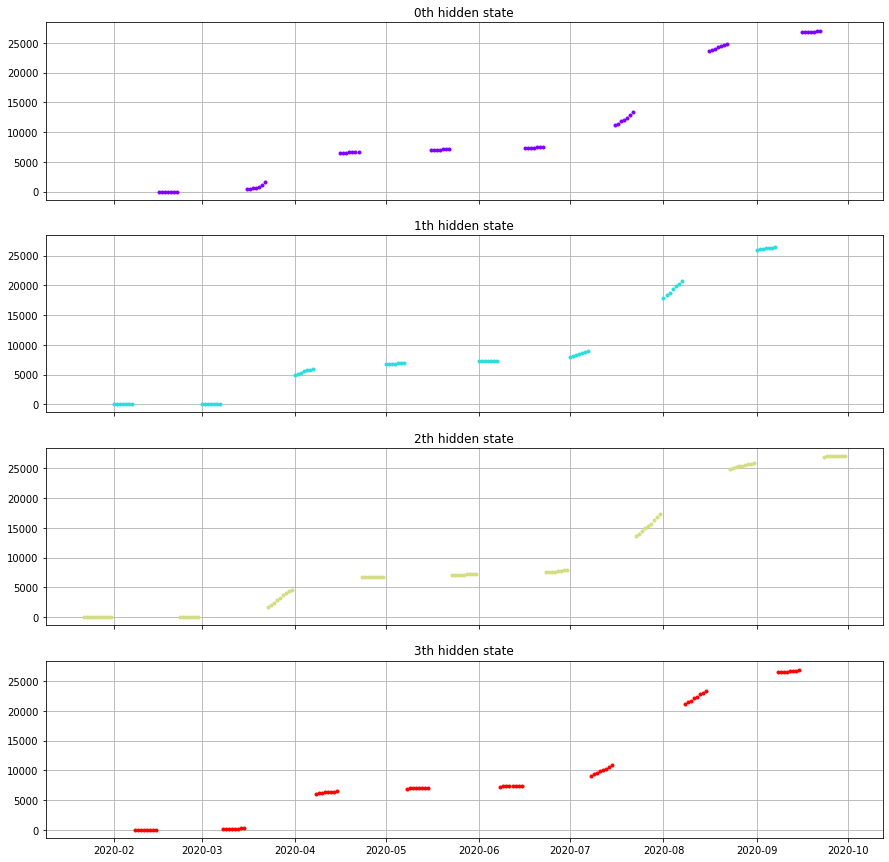

In [9]:
fig, axs = plt.subplots(model.n_components, sharex=True, sharey=True, figsize=(15,15))
colours = cm.rainbow(np.linspace(0, 1, model.n_components))

for i, (ax, colour) in enumerate(zip(axs, colours)):
    # Use fancy indexing to plot data in each state.
    mask = hidden_states == i
    ax.plot_date(df3.index[mask], y[mask], ".", c=colour,)
    ax.set_title("{0}th hidden state".format(i))

    # Format the ticks.

    ax.grid(True)
plt.show()

In [10]:

expected_returns_and_volumes = np.dot(model.transmat_, model.means_)
returns_and_volume_columnwise = list(zip(*expected_returns_and_volumes))
expected_returns = returns_and_volume_columnwise[0]
expected_volumes = returns_and_volume_columnwise[1]
params = pd.concat([pd.Series(expected_returns), pd.Series(expected_volumes)], axis=1)
params.columns= ['Expected', 'Real']
print (params)

    Expected      Real
0  20.055313  5.470209
1   5.278236  5.499686
2  24.291182  4.996549
3  12.682887  5.501973


In [12]:
matplotlib.rcParams['axes.labelsize'] = 23
matplotlib.rcParams['xtick.labelsize'] = 17
matplotlib.rcParams['ytick.labelsize'] = 17
matplotlib.rcParams['text.color'] = 'k'


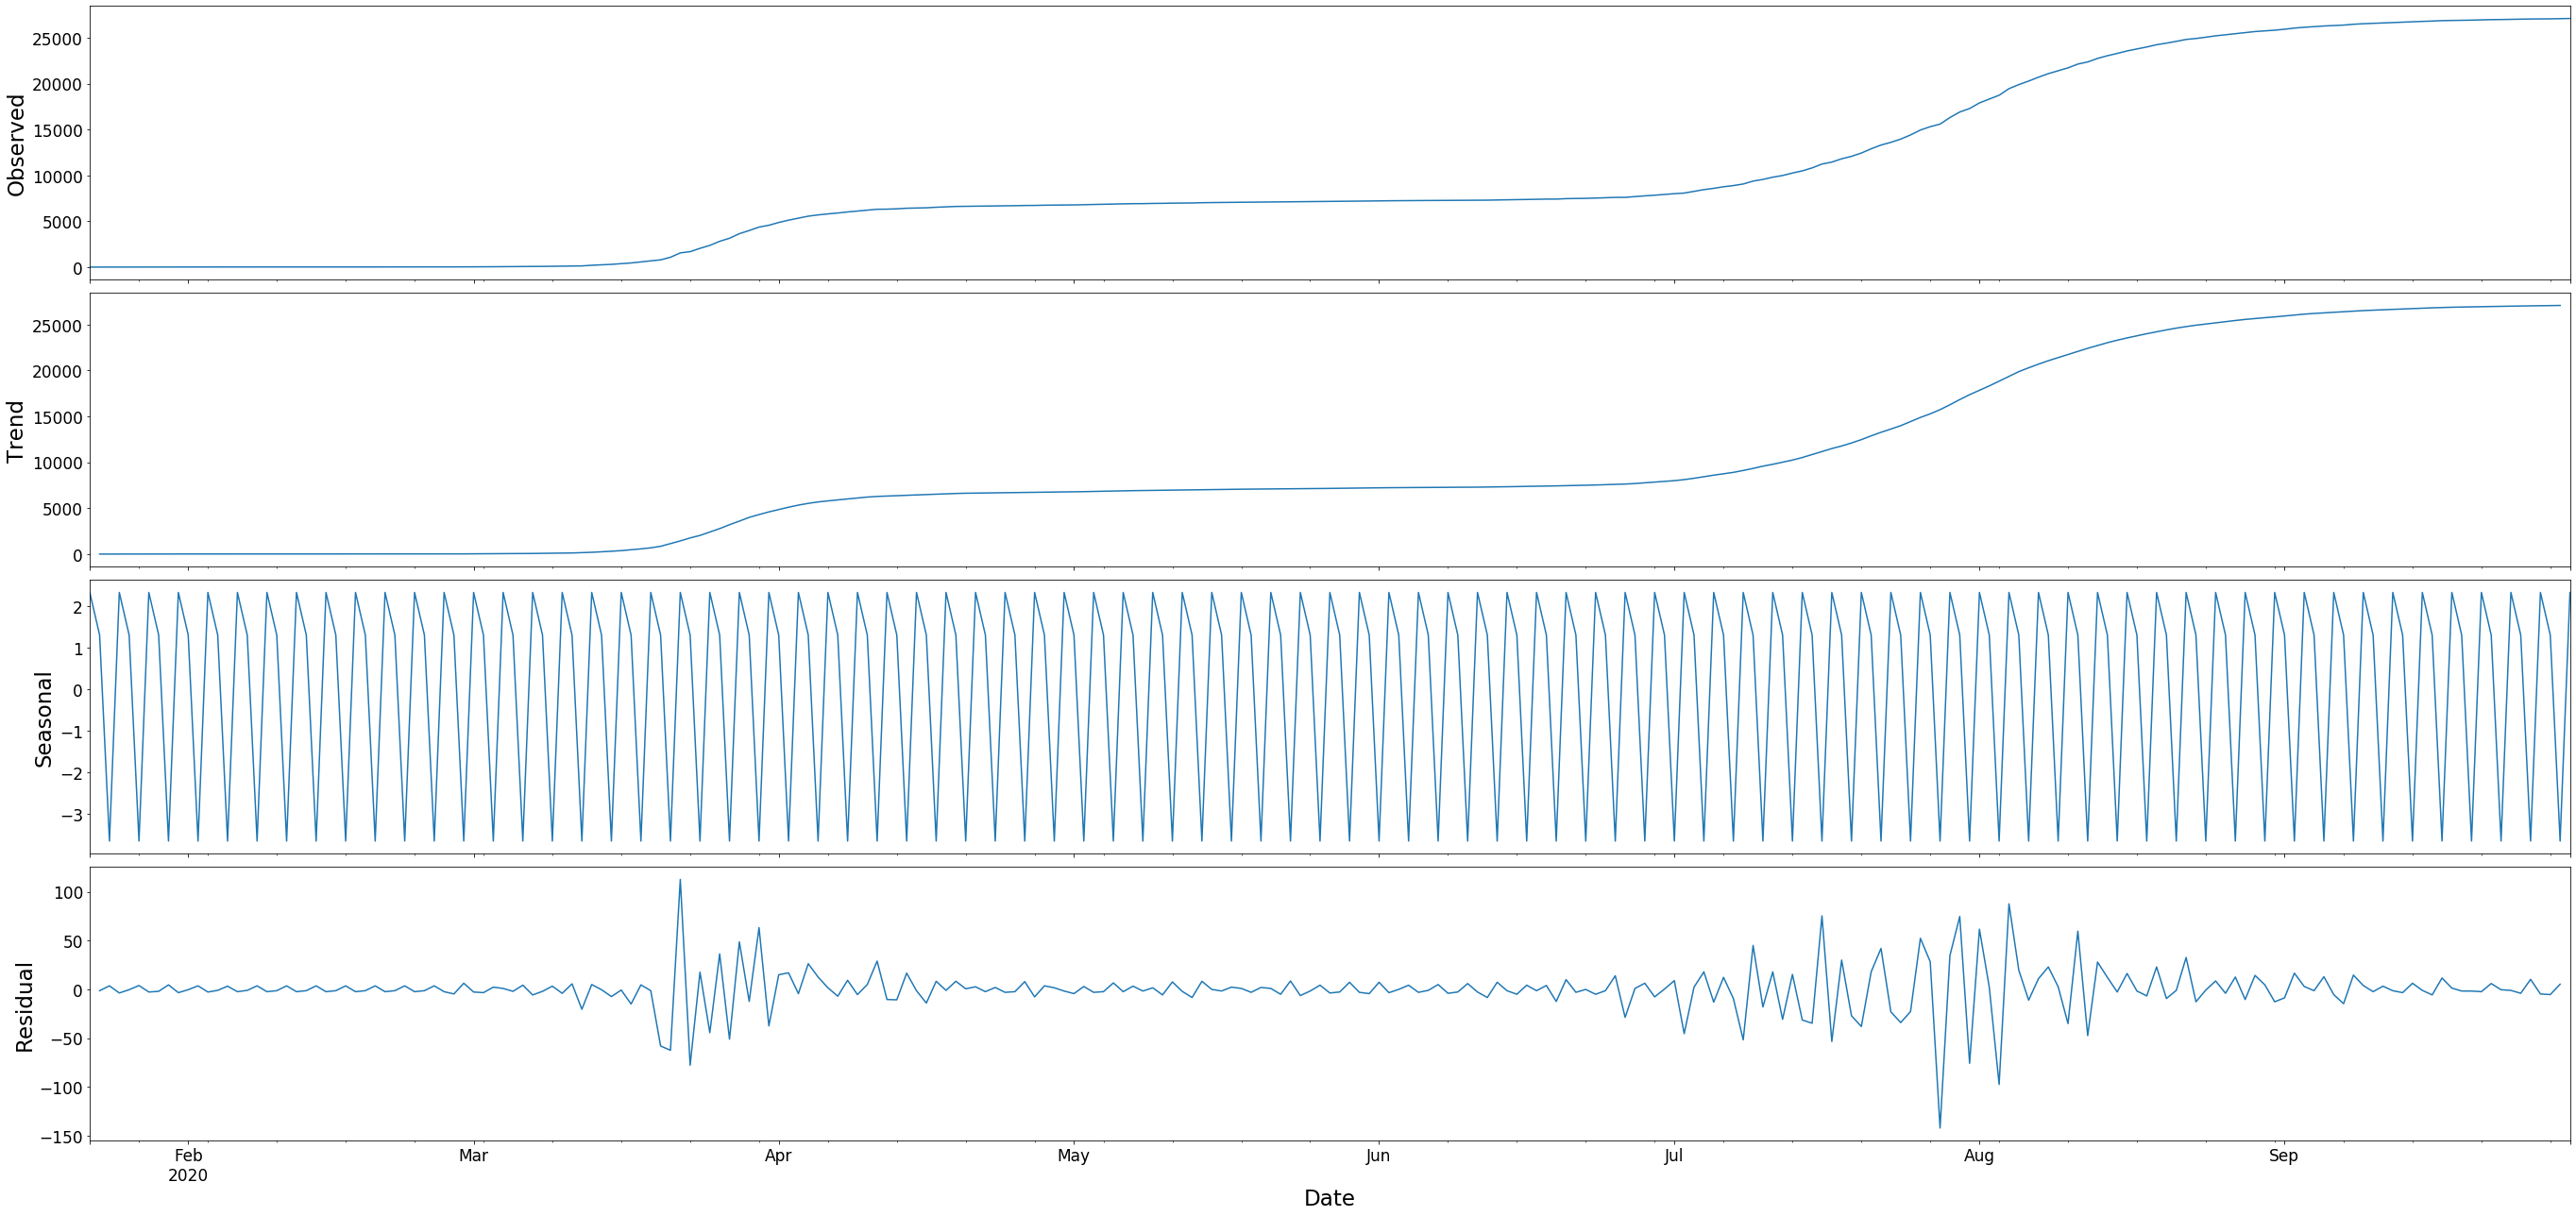

In [13]:
rcParams['figure.figsize'] = 38, 18
decomposition = sm.tsa.seasonal_decompose(df3['Aussie'], model='additive',freq=3)
fig = decomposition.plot()
plt.show()

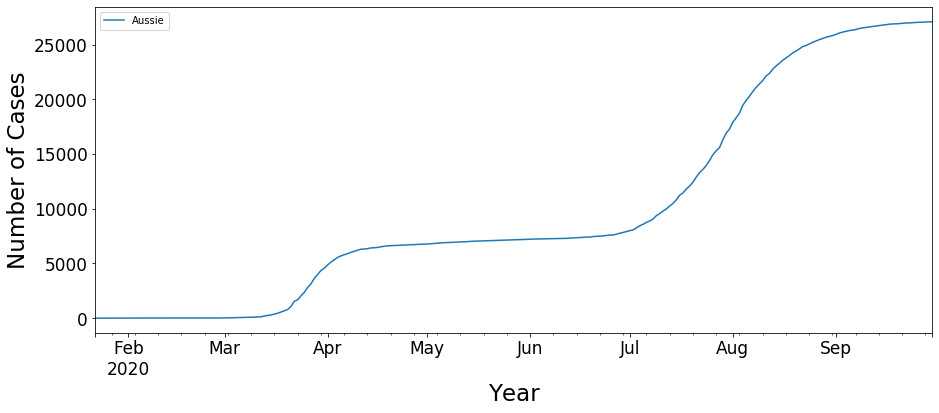

In [15]:
ax=df3.plot(y='Aussie',figsize=(15, 6))

ax.set_xlabel('Year')
ax.set_ylabel('Number of Cases')

plt.legend()
plt.show()

In [18]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))

seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)
